# Prepping works

In [3]:
import os
import pandas as pd
import numpy as np
import pprint
import json
import cv2

import pickle # Load refs and annotations
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import CLIPProcessor, CLIPModel

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO
from PIL import Image, ImageDraw


/Users/mattiacarolo/.pyenv/versions/3.9.6/envs/bagigio/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mps_device = torch.device("mps")

In [5]:
def getcaption(elem):
    li = []
    for e in elem["sentences"]:
        li.append(e['raw'])
    return li

class RefCOCOG(Dataset):
    """
    Args:
        The dataset will be the raw data wothput any tipe of preprocessing
        {
            'file_name': 
            'caption':
            'ann_id': needed to extract the relative bbox from the .json file
            'bbox': values are set like following:
                - x 
                - y
                - width 
                - height
        }
    """
    def __init__(self, refs, annotations, split="train"):

        dataset = list()

        for elem in [d for d in refs if d["split"]==split]:
            file_name = os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg')
            len_sent = len(elem['sentences'])
            sentences = elem['sentences']
            raws = []
            for i in sentences:
                raws.append(i['raw'])
            bbox = annotations[elem['ann_id']]
            for i in raws:
                dataset.append({"file_name":file_name,"raw":i,"bbox":bbox})

        self.dataset = dataset

        """
        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": tokenizer(
                                    elem["sentences"][0]["raw"], padding = "max_length", truncation=True, max_length=70,
                                    return_attention_mask = False
                                ),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]
        """
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))


In [6]:
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [7]:
def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    padded_width, padded_height = 640, 640

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    #Stores all images in a list
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        image.resize((224,224))
        images.append(transform(image))

    images = torch.stack(images, dim=0)

    data = {}
    for key in batch[0].keys():
        #if key != "file_name":
        #    data[key] = [sample[key] for sample in batch]
        data[key] = [sample[key] for sample in batch]
    return images, data

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
dataset = RefCOCOG(refs, annotations, split="test")
print(dataset[0])
print(dataset[1])
print(dataset[2])
print(dataset[3])
print("---------------------------------------------------")
#plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

{'file_name': './refcocog/images/COCO_train2014_000000380440.jpg', 'raw': 'the man in yellow coat', 'bbox': [374.31, 65.06, 136.04, 201.94]}
{'file_name': './refcocog/images/COCO_train2014_000000380440.jpg', 'raw': 'Skiier in red pants.', 'bbox': [374.31, 65.06, 136.04, 201.94]}
{'file_name': './refcocog/images/COCO_train2014_000000419645.jpg', 'raw': 'There is red colored truck in between the other trucks', 'bbox': [93.95, 83.29, 504.61, 290.57]}
{'file_name': './refcocog/images/COCO_train2014_000000419645.jpg', 'raw': 'A shiny red vintage pickup truck', 'bbox': [93.95, 83.29, 504.61, 290.57]}
---------------------------------------------------


In [27]:
%matplotlib inline

def man_bbox():
    test = dataset[0]
    bbox = test['bbox']
    x, y, width, height = bbox[0:4]
    y1=y 
    x1=x 
    y2=(y + height)
    x2=(x + width)

    image = cv2.imread("./refcocog/images/COCO_train2014_000000380440.jpg", 3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def var_bbox():
    test = dataset[0]
    bbox = test['bbox']
    x, y, width, height = bbox[0:4]
    y1=y 
    x1=x 
    y2=(y + height)
    x2=(x + width)

    image = cv2.imread("./refcocog/images/COCO_train2014_000000380440.jpg", 3)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    y_ = image.shape[0]
    x_ = image.shape[1]

    image = cv2.resize(image,(224,224))

    targetSize = 224
    x_scale = targetSize / x_
    y_scale = targetSize / y_
    print(x_scale, y_scale)

    image = np.array(image)

    (origxT, origyT, origxB, origyB) = (x1, y1, x2, y2)
    x = int(np.round(origxT * x_scale))
    y = int(np.round(origyT * y_scale))
    xmax = int(np.round(origxB * x_scale))
    ymax = int(np.round(origyB * y_scale))
    cv2.rectangle(image, (int(x), int(y)), (int(xmax), int(ymax)), (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    """
    y_ = image.shape[1]
    x_ = image.shape[0]
    targetSize = 224
    x_scale = targetSize / x_
    y_scale = targetSize / y_
    print(x_scale, y_scale)

    img = cv2.resize(image, (targetSize, targetSize));
    print(img.shape)
    img = np.array(img)

    # original frame as named values
    (origLeft, origTop, origRight, origBottom) = (y2, x1, y2, x2)

    x = int(np.round(origLeft * x_scale))
    y = int(np.round(origTop * y_scale))
    xmax = int(np.round(origRight * x_scale))
    ymax = int(np.round(origBottom * y_scale))
    # Box.drawBox([[1, 0, x, y, xmax, ymax]], img)
    drawBox([[1, 0, x, y, xmax, ymax]], img)
    """

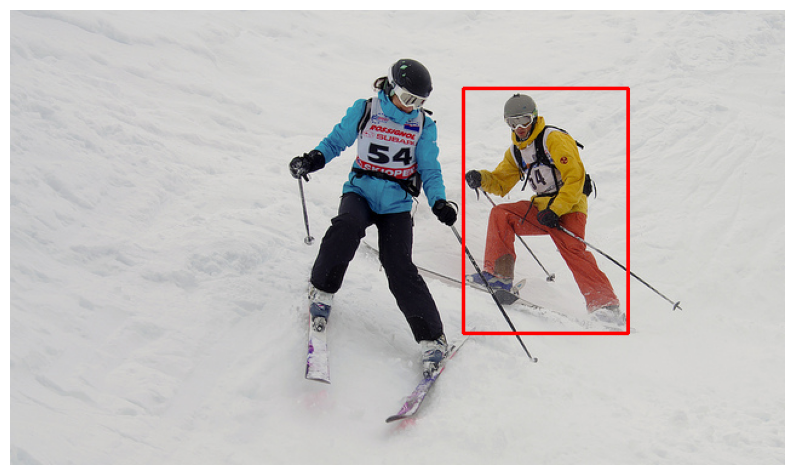

0.35 0.5957446808510638


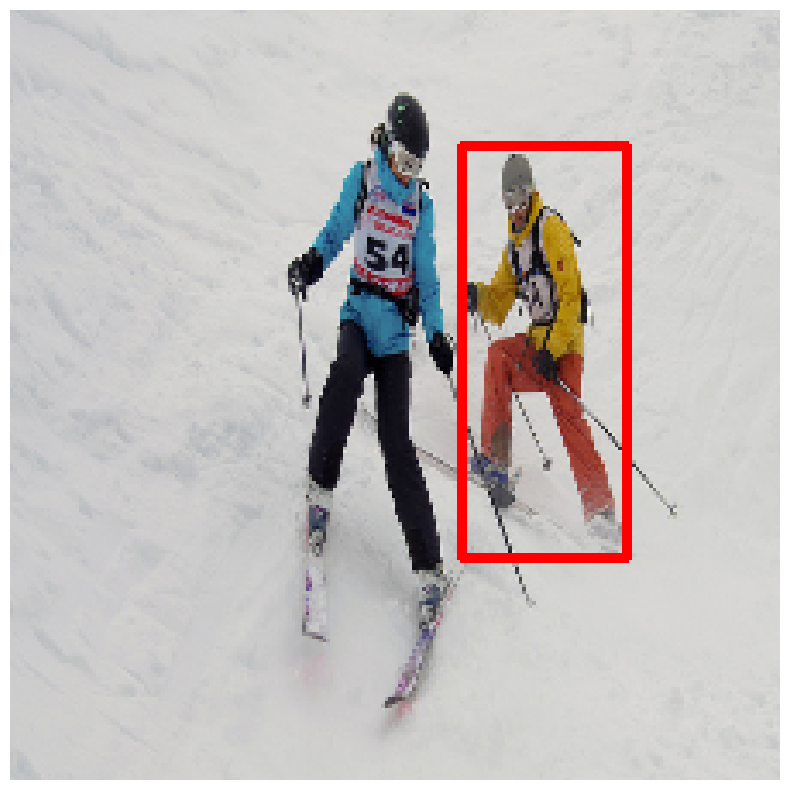

In [28]:
man_bbox()
var_bbox()

In [10]:
image = Image.open("./refcocog/images/COCO_train2014_000000380440.jpg").convert("RGB")
image.size

(640, 376)

In [11]:
first_element = next(iter(dataloader))
first_element

(tensor([[[[0.7647, 0.7490, 0.7451,  ..., 0.8275, 0.8275, 0.8078],
           [0.7922, 0.7961, 0.7922,  ..., 0.8235, 0.8275, 0.8235],
           [0.7882, 0.7922, 0.7882,  ..., 0.8314, 0.8235, 0.8118],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.7686, 0.7529, 0.7490,  ..., 0.8275, 0.8275, 0.8078],
           [0.7922, 0.7961, 0.7922,  ..., 0.8235, 0.8275, 0.8235],
           [0.7882, 0.7922, 0.7882,  ..., 0.8314, 0.8235, 0.8157],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.7765, 0.7608, 0.7569,  ..., 0.8275, 0.8275, 0.8000],
           [0.8000, 0.8039, 0.8000,  ..., 0.8235, 0.8196, 0.8157],
           [0.7961, 0.80

## Conteggio occorrenze caption per image

In [12]:
# Models
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/mattiacarolo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-2 Python-3.9.6 torch-2.3.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Image Encoder

In [13]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)   
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

Using cache found in /Users/mattiacarolo/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /Users/mattiacarolo/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [14]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/mattiacarolo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-2 Python-3.9.6 torch-2.3.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [15]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(self, model):
        super().__init__()
        self.model = model
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [16]:
visual_model = ImageEncoder(yolo_model)

In [17]:
img_path = dataset[1]['file_name']
print(img_path)
results = visual_model(img_path)
print(results.xyxy)

./refcocog/images/COCO_train2014_000000380440.jpg
[tensor([[3.76612e+02, 6.71787e+01, 5.11144e+02, 2.62757e+02, 9.30587e-01, 0.00000e+00],
        [2.30679e+02, 4.31513e+01, 3.71294e+02, 3.07864e+02, 9.30456e-01, 0.00000e+00],
        [2.44575e+02, 2.57017e+02, 3.77800e+02, 3.43933e+02, 7.03473e-01, 3.00000e+01],
        [3.46710e+02, 2.12951e+02, 5.18615e+02, 2.68029e+02, 4.47434e-01, 3.00000e+01]])]


## Text Encoder

In [18]:
clip.tokenize(dataset[0]['raw'])
model, preprocess = clip.load("RN50")

In [19]:
def cleancrops8(crops):
    newcrops = []
    temp = list(crops)
    for c in temp:
        c=c.tolist()
        x, y, width, height = c[0:4]
        y1=y 
        x1=x 
        y2=(y + height)
        x2=(x + width)
        bbox = [x1, y1, x2, y2]
    
        newcrops.append(bbox)

    return newcrops

def crop_image(image_path, bounding_box):
    # Load the image
    image = Image.open(image_path[0]).convert("RGB")

    # Extract the bounding box coordinates
    x_min, y_min, x_max, y_max = bounding_box
    # Crop the image using the bounding box coordinates
    cropped_image = image.crop((x_min, y_min, x_max, y_max))
    # Convert the cropped image to a NumPy array
    cropped_array = np.array(cropped_image)

    return cropped_array


def find_best_yolo_bbox5(sentence, image, net, vmodel, filename):
    results = vmodel(filename)       #yolo computes the bounding boxes of a given image
    crops = results.xyxy[0]

    goodcrops = cleancrops8(crops)  #fixing them to a usable format

    #tok_text = clip.tokenize(sentence).to(device)   #preparing the text
    tok_text = clip.tokenize(sentence)

    #best_sim = torch.tensor([[0.0]]).to(device)
    best_sim = torch.tensor([[0.0]])
    best_crop = None

    if len(goodcrops) == 0:
        return [0,0,0,0], 0
    else:
        for crop in goodcrops:
            cropped_image = crop_image(filename, crop)                  #clip computes the most similar cropped image 
            img = Image.fromarray(cropped_image)                     #to the given sentence
            #img_tens = preprocess(img).unsqueeze(0).to(device)
            img_tens = preprocess(img).unsqueeze(0)

            images_z = net.encode_image(img_tens).float()
            texts_z = net.encode_text(tok_text).float()

            temp_sim = cosine_similarity(images_z, texts_z)
            if temp_sim > best_sim:
                best_sim = temp_sim
                best_crop = crop

    return best_crop, best_sim      #returns the best bounding box and the similarity score

def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  #return similarity.to(device)
  return similarity

In [20]:
#this function computes the IOU score between two bounding boxes
def compute_iou(bb1, bb2):
    #determining the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[0]+bb1[2], bb2[0]+bb2[2])
    y_bottom = min(bb1[1]+bb1[3], bb2[1]+bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    #computing the area of both bboxes
    bb1_area = bb1[2] * bb1[3]
    bb2_area = bb2[2] * bb2[3]
    
    #computing iou
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

: 

In [21]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device)
#clip_model.eval()
#text = clip.tokenize(q).to(device)
# Define optimizer
optimizer = optim.Adam(list(yolo_model.parameters()) + list(clip_model.parameters()), lr=1e-4)
samples = 0.0
cumulative_accuracy = 0.0
cumulative_iou = 0.0
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for image, data in dataloader:
        image = image.to(device)
        text = data['raw']
        bbox = data['bbox']
        file_name = data['file_name']
        tok = clip.tokenize(text)

        best_bb, simil = find_best_yolo_bbox5(text, image, clip_model, visual_model,file_name)
        """
        iouscore = compute_iou(best_bb,bbox[0])
        cumulative_iou += iouscore
        cumulative_accuracy += simil
        samples += 1
        """
cumulative_accuracy = cumulative_accuracy / samples * 100
cumulative_iou = cumulative_iou / samples * 100
        

## Baseline

Using cache found in /Users/mattiacarolo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-2 Python-3.9.6 torch-2.3.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Image file name: ./refcocog/images/COCO_train2014_000000380440.jpg

CAPTION:  Skiier in red pants.
RESULTS (bounding boxes): 
[     376.61      67.179      511.14      262.76     0.93059           0]
[     230.68      43.151      371.29      307.86     0.93046           0]
[     244.57      257.02       377.8      343.93     0.70347          30]
[     346.71      212.95      518.61      268.03     0.44743          30]
TARGET (bounding box):  [374.31, 65.06, 136.04, 201.94]
374.31 65.06 510.35 267.0


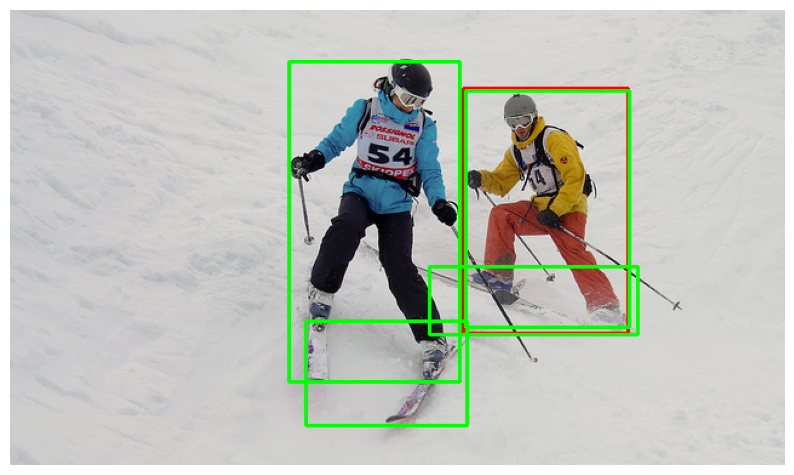

In [ ]:
%matplotlib inline

# Load YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load an image and target bounding box from the dataset
img_path = dataset[1]['file_name']
print("Image file name:", img_path)
# Query (caption)
q = dataset[1]['raw']
# Target bounding box
target_bbox = dataset[1]['bbox']  # Assuming format [x1, y1, x2, y2]

# Perform inference
results = yolo_model(img_path)

# Extract bounding boxes from the results
bboxes = results.xyxy[0].cpu().numpy()

# Print the caption
print("\nCAPTION: ", q)

# Print the bounding boxes detected by the model
print("RESULTS (bounding boxes): ")
for bbox in bboxes:
    print(bbox)

# Print the target bounding box
print("TARGET (bounding box): ", target_bbox)

# Visualize the results
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw target bounding box in red
x, y, width, height = target_bbox
h,w,c = img.shape
y1=y 
x1=x 
y2=(y + height)
x2=(x + width)

print(x1,y1,x2,y2)
cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

# Draw detected bounding boxes in green
for bbox in bboxes:
    x1, y1, x2, y2, conf, cls = bbox
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
print(results)

image 1/1: 480x640 3 persons, 3 cups, 1 fork, 1 bowl, 3 apples, 1 tv, 1 vase
Speed: 7.1ms pre-process, 85.2ms inference, 0.5ms NMS per image at shape (1, 3, 480, 640)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)
#text = clip.tokenize(q).to(device)

In [ ]:
# definition of recall metric
class Recall:
    def __init__(self):
        self.true_positives = 0
        self.false_negatives = 0

    def update(self, correct):
        if correct:
            self.true_positives += 1
        else:
            self.false_negatives += 1

    def compute(self):
        return self.true_positives / (self.true_positives + self.false_negatives)

    def reset(self):
        self.true_positives = 0
        self.false_negatives = 0
class Metrics:
    def __init__(self, model, name):
        self.name = name
        self.treshold = 0.5
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        ])
        # initialize torch tensor
        self.iou = torch.tensor([]).cuda()
        self.recall = Recall()
        self.model = model
        self.cosine_similarity = torch.tensor([]).cuda()
        self.euclidean_distance = torch.tensor([]).cuda()

    #method that updates the metrics
    def update(self, predicted_bbox, target_bbox, predicted_image, target_image):
        predicted_bbox = torch.tensor(predicted_bbox)
        target_bbox = torch.tensor(target_bbox)

        with torch.no_grad():
            # Preprocess the predicted image and compute the predicted embedding
            predicted_image = padd_image(predicted_image)
            image_tensor = self.transform(predicted_image)
            image_tensor = image_tensor.unsqueeze(0).cuda()
            predicted_embedding = self.model.encode_image(image_tensor)

            # Preprocess the target image and compute the target embedding
            target_image = padd_image(target_image)
            target_image_tensor = self.transform(target_image)
            target_image_tensor = target_image_tensor.unsqueeze(0).cuda()
            target_embedding = self.model.encode_image(target_image_tensor)

        # compute cosine similarity and euclidean distance
        similarity = torch.nn.functional.cosine_similarity(predicted_embedding, target_embedding)
        distance = torch.nn.functional.pairwise_distance(predicted_embedding, target_embedding)

        # convert bboxes into torch tensors
        predicted_bbox = torch.tensor(predicted_bbox)
        target_bbox = torch.tensor(target_bbox)

        predicted_bbox = convert_yolo_bbox(predicted_bbox)

        # compute iou for the specific image
        actual_iou = ops.box_iou(predicted_bbox.unsqueeze(0).cuda(), target_bbox.unsqueeze(0).cuda())
        self.iou = torch.cat((self.iou, actual_iou), 0)

        # update recall based on iou treshold
        if actual_iou > self.treshold:
            self.recall.update(True)
        else:
            self.recall.update(False)

        # update cosine similarity and euclidean distance
        self.cosine_similarity = torch.cat((self.cosine_similarity, similarity), 0)
        self.euclidean_distance = torch.cat((self.euclidean_distance, distance), 0)

    def to_string(self):
        #compute metrics
        mean_iou = torch.mean(self.iou)
        recall_at_05_iou = self.recall.compute()
        mean_cosine_similarity = torch.mean(self.cosine_similarity)
        mean_euclidean_distance = torch.mean(self.euclidean_distance)

        return f"Mean IoU: {mean_iou:.4f}, Recall@0.5 IoU: {recall_at_05_iou:.4f}, Mean Cosine Similarity: {mean_cosine_similarity:.4f}, Mean Euclidean Distance: {mean_euclidean_distance:.4f}"

    #method that saves the metrics in csv files
    def  save(self):
        iou = self.iou.cpu().numpy()
        cosine_similarity = self.cosine_similarity.cpu().numpy()
        euclidean_distance = self.euclidean_distance.cpu().numpy()

        np.savetxt(self.name+"_iou.csv", iou, delimiter=",")
        np.savetxt(self.name+"_cosine_similarity.csv", cosine_similarity, delimiter=",")
        np.savetxt(self.name+"_euclidean_distance.csv", euclidean_distance, delimiter=",")

    def reset(self):
        self.iou = torch.tensor([]).cuda()
        self.recall.reset()
        self.cosine_similarity = torch.tensor([]).cuda()
        self.euclidean_distance = torch.tensor([]).cuda()

In [ ]:
# class that defines the baseline model
class VisualGrounding_baseline(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_baseline, self).__init__()
        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load(
            'ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.name = "baseline"
        # define metrics
        self.metrics = Metrics(self.clip, self.name)

        

    def forward(self, img_path, sentence):
        max_similarity = 0
        max_image = None
        max_bbox = None

        # get yolo output
        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")
        text = clip.tokenize([sentence]).cuda()
        with torch.no_grad():
            text_features = self.clip.encode_text(text).float()

        for i in range(len(yolo_output.xyxy[0])):
            #crop the image based on the yolo output
            img_cropped = crop_yolo(yolo_output, original_img, i)

            img = self.preprocess(img_cropped).cuda().unsqueeze(0)

            with torch.no_grad():
                #calculate embeddings
                image_features = self.clip.encode_image(img).float()

            #compute cosine similarity
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

            if similarity > max_similarity:
                max_similarity = similarity
                max_image = img_cropped
                max_bbox = yolo_output.xyxy[0][i]

        if max_image is None:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()

    def save_metrics(self):
        self.metrics.save()